### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성청년SW·AI아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

### **Objectives**
1. 실습명 : PEFT(Parameter-Efficient Fine-Tuning of Billion-Scale Models on Low-Resource Hardware)(파라미터 효율적 튜닝)
2. 핵심 주제: 실습 전반에 걸쳐서 익히게 되는 핵심 주제 3가지를 나열해주세요.
    1. Unsloth에 대한 이해
    2. LoRA에 대한 이해
    3. LoRA를 이용한 학습
3. 학습 목표 :
    1. Base 모델 및 토크나이저를 load할 수 있다.
    2. LoRA 설정 및 해당 설정을 모델에 적용할 수 있다.
    3. LoRA 학습을 위한 데이터셋 준비와 전처리를 할 수 있다.
    4. LoRA 모델을 학습하고 저장할 수 있다.
    5. LoRA fine-tuned model을 이용하여 모델 추론을 할 수 있다.
4. 학습 개념:
    1. UnSloth
    2. LoRA
    3. fine-tuning
5. 학습 방향 :
   - 실습은 코드를 실행해가며 LoRA를 이용한 학습 방식에 대해서 이해하고 직접 학습을 진행해봅니다.
   - 실습 코드는 조교가 직접 구현한 코드를 참고하여 학습합니다.
   - 해당 실습은 모델을 학습하는 과정이므로 모델이 어떠한 과정을 거쳐서 학습되는지에 대한 개괄적인 이해도를 높이는데 초점을 맞춥니다.
6. 데이터셋 개요 및 저작권 정보
    - 데이터셋 명 : [arcee-ai/The-Tome](https://huggingface.co/datasets/arcee-ai/The-Tome)
    - 데이터셋 개요 : instruction following을 위한 curated dataset
    - 데이터셋 저작권 : MIT



### **Prerequisites**

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.55.4

# 1. Unsloth

- Unsloth에 대해서 알아봅니다.
- Unsloth를 이용하여 모델을 불러봅니다.


<blockquote>
<b>🧠 Unsloth란?</b><br>
Unsloth는 효율적인 LLM(대형 언어 모델) 파인튜닝 및 강화학습(RL) 프레임워크로, 속도와 메모리 관리 측면에서 최적화된 성능을 제공합니다.
</blockquote>

- 수작업으로 유도된 수학 연산과 GPU 커널을 직접 작성해서 기존보다 훨씬 빠르게 학습이 가능하도록 설계됨  ￼ ￼.
- 오픈소스이며 무료 버전 제공, Google Colab이나 Kaggle에서도 손쉽게 사용 가능  ￼.

1. 학습 속도와 메모리 효율
- 기존 FlashAttention 2 기반보다 최대 30배 빠른 학습 속도와 메모리( VRAM) 30% 절감  ￼.
- 알파카(Alpaca) 데이터셋 벤치마크 기준으로 Llama 3.3 (70B) 모델에서 학습 속도 2배, VRAM 75% 이상 절감, 컨텍스트 길이 13배 향상  ￼.

2. 세부 기술적 장점
- 최적화된 Attention·MLP·Normalization 구현, 직접 작성된 Triton 커널, torch.compile 사용 등을 통한 성능 개선  ￼.
- QLoRA, LoRA, 4‑/8‑/16‑bit 등 저정밀 훈련 지원, VRAM 요구량을 최소화하면서도 정확도 유지  ￼.
- RSLORA, LoftQ, 장기 컨텍스트 학습, 멀티모달 VLM 등 최신 기법 지원

사용할 모델 : [google/gemma-3-1b-it](https://huggingface.co/google/gemma-3-1b-it)
- 구글에서 공개한 오픈소스 모델

아래 코드를 실행하여 모델과 토크나이저를 불러옵니다.

여기서 특이한 점은 `google/~~~` 모델을 사용하는 것이 아닌 [`unsloth/~~~~`]를 사용한다는 점입니다. Fine-tuning에 특화된 버전으로 Unsloth가 양자화하여 변형한 모델입니다.

In [ ]:
from unsloth import FastModel
import torch
max_seq_length = 2048 # 학습 메모리를 위해서 우선 작게 설정합니다.
model_name = "unsloth/gemma-3-1b-it-unsloth-bnb-4bit" # Gemma-3-1B의 4bit 양자화한 모델
# 양자화 했다. : 정밀도를 조금 희생하는 대신, 모델을 훨씬 가볍고 메모리 효율적으로 만드는 방법
# 부동소수점(FP32, FP16)으로 저장‧연산하던 모델의 가중치를
# 더 작은 비트 수(INT8, INT4 등)로 표현하여 모델 크기와 메모리를 줄이는 기술

model, tokenizer = FastModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length, # Choose any for long context!
    # load_in_4bit=True # Qlora 형태로 사용하고 싶다면
    # -> Qlora는 기존 모델의 가중치(Weight)만 4bit로 양자화하고, LoRA 학습은 원래 정밀도로 수행하는 방식
    # 양자화된 weight로 불러올 것이냐”, “원본 weight(FP16/FP32)로 불러올 것이냐
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.7: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

# 2. LoRA 설정

- LoRA의 개념과 그에 따른 설정값들에 대해서 알아봅니다.

### **LoRA의 원리**
- LoRA와 관련해서는 아래 이미지가 아주 유명합니다.
  
<img src = "https://raw.githubusercontent.com/Ssunbell/TIL/refs/heads/master/assets/LoRA_Adaptation.png" />
    
  기존에 모델을 구성하고 있던 계층들과는 별개의 파라미터를 사용하는 개념 중 하나가 Adapter입니다.
    
  색상으로도 나름 표시를 해둔 것이, 기존 모델의 Pretrained Weights는 학습을 하지 않고 (Freeze❄️), Adapter에 해당되는 모듈만 학습을 합니다. (Trainable🔥)
    
- 모델은 입력(텍스트)을 받으면 이를 숫자로 변환해 수많은 layer들을 통과하면서 연산을 수행하고 그 결과를 반환(output)합니다.
    
<img src="https://raw.githubusercontent.com/Ssunbell/TIL/refs/heads/master/assets/LoRA.png" />
    
  이때 결과물과 실제 정답(label) 간의 오차 정도를 바탕으로 역전파를 수행하며 파라미터를 업데이트 하는데요, LoRA에서는 업데이트를 그림 중 ‘우측🔥’에만 수행합니다.
    
  즉, forward 연산은 pretrained weights 따로, adapter 따로 수행하고요 각각의 결과를 합쳐 다음 레이어에 보내는데, backward에서 gradient update는 adapter🔥에만 적용한다는 뜻입니다.
    
- **이렇게 하면 장점이 뭔가요?**
    
    LLM을 학습할 때 대부분의 메모리와 시간을 차지하는 것은 역전파 과정입니다.
    
    역전파를 위해서는 forward에 사용된 QKV 값들을 저장해두어야 하고 이것이 메모리에 담겨 있기 때문이죠.
    
    또한 역전파 자체도 기존의 수치미분 방식에 비하면 엄청나게 효율적이지만 수억 ~ 수백억개의 파라미터를 업데이트 해야 하는 상황에서는 병목이 될 수밖에 없습니다.
    
    그런데 pretrained weights❄️ 는 역전파가 필요하지 않고, adapter🔥 는 파라미터수가 굉장히 적습니다.
    
    실제로 LoRA 세팅 이후 trainable parameters를 출력해보면 기존 모델 파라미터의 1% 내외를 차지하게 됩니다.
    
    **→ 따라서 학습에 필요한 메모리와 시간을 획기적으로 줄일 수 있습니다.**
    
- **그런데 결국 Pretrained Weights \(W\) (❄️) 와 Adapter(🔥) 가 분리되어 있다면,  
  Forward 기반 Inference 시에는 비효율적인 것 아닌가요?**

  날카로운 지적입니다.

  맞습니다. 학습이 끝난 뒤 **추론 단계**에서는 다음과 같은 형태로 계산됩니다.

  $$
  W_{\text{final}} = W + \Delta W
  $$

  즉, Forward 시 두 경로를 모두 거쳐야 하므로 **연산량이 증가**합니다.

  이를 해결하기 위해 LoRA는 **학습 후 Adapter를 Merge**합니다.

  즉,

  **"학습이 끝난 Adapter를 원래 가중치 \(W\) 에 더하여 하나의 Weight로 합친다"**

---

### Adapter의 구조

LoRA는 두 개의 저차원 행렬로 업데이트를 근사합니다.

$$
A \in \mathbb{R}^{r \times d}, \quad B \in \mathbb{R}^{d \times r}
$$

따라서 Adapter 업데이트는 다음과 같습니다.

$$
\Delta W = BA \in \mathbb{R}^{d \times d}
$$

이는 Pretrained Weight의 차원과 동일합니다.

$$
W \in \mathbb{R}^{d \times d}
$$

---

### Merge 과정

따라서 Merge는 단순히 합 연산으로 정의됩니다.

$$
W_{\text{final}} = W + \Delta W
$$

Merge 후에는 Adapter가 없어도 Weight가 하나로 통합되므로  
**Inference 속도와 메모리 사용 모두 유리**합니다.

---

### 시각적 요약
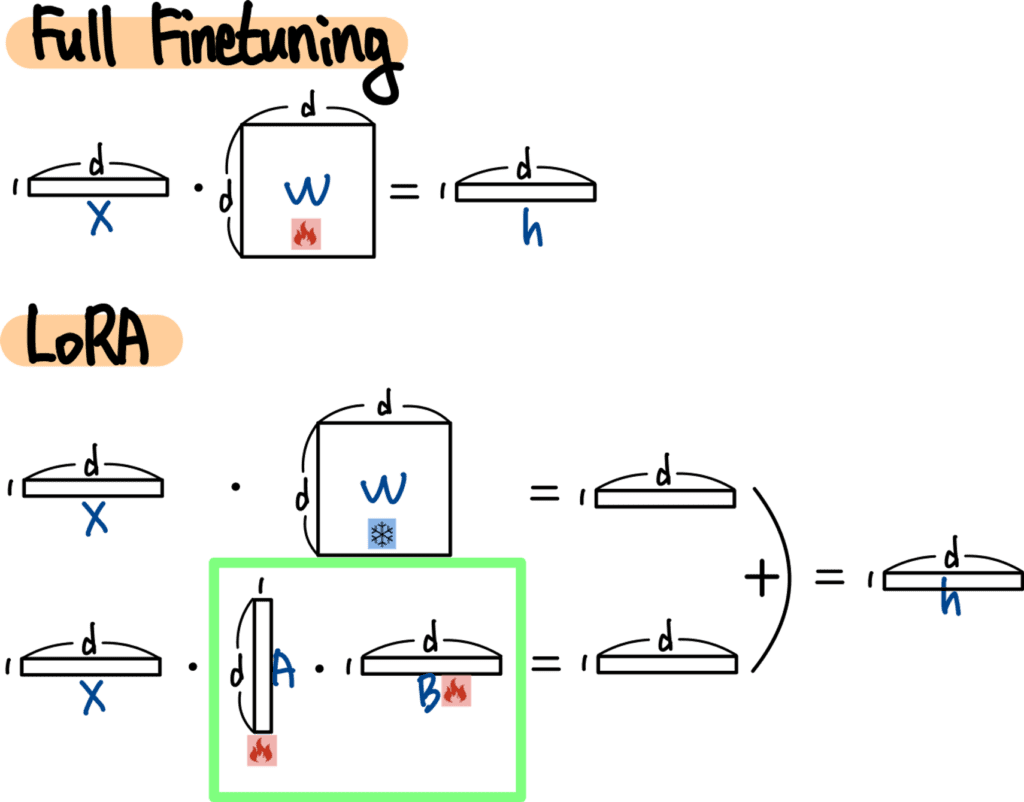
| 단계 | Weight 형태 | 추론 방식 |
|---|---|---|
| 학습 중 | W + BA 형태 | Adapter 별도, LoRA 학습 |
| 학습 후 (Merge 전) | W + BA 형태 | Forward 시 두 Weight 합산 필요 |
| 학습 후 (Merge 후) | W_merged 형태 | 단일 Weight, 빠른 추론 |
---

- A×B로 만든 ΔW가 x와 곱해지고, 그 결과가 W에서 나온 벡터와 더해져서 하나의 벡터가 되는 개념

"그걸 그냥 더한다고 정말 괜찮은가?" 라고 생각할 수 있지만,  
이는 **Microsoft LoRA 논문에서 실험적으로 검증된 결과**이므로 안심하고 적용해도 됩니다.

        


### **LoRA 구현**
- 참고 가능한 링크 🔗: https://huggingface.co/docs/peft/main/en/conceptual_guides/lora#lora-examples, https://huggingface.co/docs/peft/en/index
- HuggingFace의 Trainer 클래스를 사용한다는 것을 전제로 두고, 추가로 작성해야 하는 코드만 제시하겠습니다. (위 링크의 내용과 살짝 다릅니다)
- LoRA를 사용하기 위해서는 HuggingFace에서 지원하는 PEFT 라이브러리를 다운로드 받아야 합니다.
    
    Parameter Efficient Fine-Tuning 의 약자로 LoRA, Quantization, Prefix tuning 등 다양한 학습 방식들을 지원합니다.
    
- 기존 학습/추론 로직
    
    “데이터 불러오기 → 데이터셋 클래스로 만들기 → 모델, 학습 args 불러오기 → Trainer로 ‘데이터, 모델, args’ 감싸기 → `Trainer.train()`”
    
- LoRA 추가 시 학습/추론 로직
    
    “데이터 불러오기 → 데이터셋 클래스로 만들기 → 모델, 학습 args 불러오기 → **PEFT(LoRA) config** 설정하기 → Trainer로 ‘데이터, 모델, args, **PEFT(LoRA) config**’ 감싸기 → `Trainer.train()`”
    
- 학습 코드 예시
    
```python
from peft import LoraConfig

...

training_args = TrainingArguments(
        ...
)

peft_config = LoraConfig(
    r=args.lora_r,
    lora_alpha=args.lora_alpha,
    lora_dropout=args.lora_dropout,
    bias=args.lora_bias,
    task_type=args.task_type,
    target_modules=args.target_modules
)

trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    peft_config=peft_config if args.peft else None,
)

trainer.train()
trainer.save_model(args.output_dir)

```
    
- 추론 시 merge 코드
    
```python
if peft_config is not None:
    model = trainer.model.merge_and_unload()

with torch.no_grad():
        ...

```

### **arguments 간단히 알아보기**
    
당연히 여러 요소들이 영향을 미치지만.. 영향력이 가장 큰 세 개의 argument만 살펴보겠습니다. 좀더 자세한 설명은 [LoRA Hyperparameters Guide](https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide#hyperparameters-and-recommendations)를 참고해주세요

- `r`: $A \in \mathbb{R}^{r \times d}, B \in \mathbb{R}^{d \times r}$를 구성하는 차원 r을 결정합니다. 보통 8, 16, 32, 64 중 하나의 값을 가집니다.
- `lora_alpha`: adapter의 weight를 scaling 할 때 사용하는 값입니다. weight 전체에 $\alpha/r$ 를 곱합니다. 즉, $\alpha$의 값이 클수록 adapter의 영향력이 커지는 것으로 이해할 수 있습니다.
- `target_modules`: 어떤 layer에 adapter를 추가할 것인지 결정합니다. 커스텀 여지가 많은 부분인데 보통은 `Linear` 레이어에 LoRA를 적용합니다. 자세한 내용은 검색해보시길 추천드립니다.
    - Attention: `q_proj`, `k_proj`, `v_proj`, `o_proj`
    - MLP: `gate_proj`, `up_proj`, `down_proj`
    - PEFT documentation 일부 내용
        - **target_modules** (`Optional[Union[List[str], str]]`) — The names of the modules to apply the adapter to. If this is specified, only the modules with the specified names will be replaced. When passing a string, a regex match will be performed. When passing a list of strings, either an exact match will be performed or it is checked if the name of the module ends with any of the passed strings. If this is specified as ‘all-linear’, then all linear/Conv1D modules are chosen, excluding the output layer. If this is not specified, modules will be chosen according to the model architecture. If the architecture is not known, an error will be raised — in this case, you should specify the target modules manually.

In [ ]:
r = 8 # 어떤 숫자를 사용해도 상관없지만, 8, 16, 32, 64, 128 단위를 추천드립니다!, LoRA에서 학습할 저차원 벡터(rank) 의 크기
target_modules = [
    "q_proj",    # Self-Attention에서 Query 벡터 생성 (현재 토큰이 어떤 정보를 찾을지 결정)
    "k_proj",    # Self-Attention에서 Key 벡터 생성 (모든 토큰의 정보 인덱싱 역할)
    "v_proj",    # Self-Attention에서 Value 벡터 생성 (토큰의 실제 의미 정보 전달)
    "o_proj",    # Self-Attention 결과를 통합해 다음 레이어로 전달
    "gate_proj", # Feed Forward(MLP)에서 활성화 전 게이팅 역할, 정보 흐름 조절
    "up_proj",   # Feed Forward(MLP)에서 차원 확장 (hidden_dim → 4×hidden_dim)
    "down_proj"  # Feed Forward(MLP)에서 차원 축소 (4×hidden_dim → hidden_dim)
]

lora_alpha = 16   # LoRA의 스케일링 팩터 (보통 alpha = r * 2), 업데이트 강도를 조절 - 학습된 LoRA 업데이트를 얼마나 크게 반영할 것인가?
lora_dropout = 0.0 # LoRA 입력에 적용되는 드롭아웃 비율, 일반적으로 0.0이 가장 안정적 - LoRA가 너무 특정 패턴에만 과적합되지 않게
bias = "none"     # Bias 파라미터는 학습하지 않음 (LoRA는 W 가중치만 보정하므로 none 권장)

model = FastModel.get_peft_model(
    model,
    r = r,
    target_modules = target_modules,
    lora_alpha = lora_alpha,
    lora_dropout = lora_dropout,
    bias = bias
)

Unsloth: Making `model.base_model.model.model` require gradients


# 3. 데이터셋 준비 및 전처리
우리는 이제 chat fine-tuning을 위해 Gemma-3 포맷을 사용합니다. 여기서는 [Thytu's ChessInstruct](https://huggingface.co/datasets/Thytu/ChessInstruct) 데이터셋을 사용합니다.
Gemma-3는 멀티 턴 대화를 아래와 같이 렌더링합니다:

여기서의 데이터 값은 a1a4와 같이 이동 전, 이동 후의 좌표를 나타냅니다.

```
<bos><start_of_turn>user
Hello!<end_of_turn>
<start_of_turn>model
Hey there!<end_of_turn>
```

Unsloth는 `get_chat_template` 함수를 사용하여 올바른 채팅 템플릿을 불러옵니다.
현재 zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, phi3, llama3, phi4, qwen2.5, gemma3 등 다양한 템플릿을 지원합니다.

In [ ]:
from unsloth.chat_templates import get_chat_template
# 모델이 어떤 대화 포맷으로 말을 걸어야 이해하는지를 알려주는 대화 가이드
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma3",
)

`reasoning_effort`을 `medium`으로 변경하면 모델이 더 오래 생각하게 됩니다.

따라서 생성되는 토큰 수를 감당할 수 있도록 `max_new_tokens` 값을 늘려야 하지만, 그 결과 더 나은 답변과 더 정확한 답변을 얻을 수 있습니다.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Thytu/ChessInstruct", split = "train[:10000]")
# 체스 설명에 대한 데이터
# 체스판의 이전 수(move)들과 경기 결과를 보고, 모델이 마지막 한 수(또는 다음 수)를 합리적으로 추론하도록 학습시키는 Reasoning용 instruction dataset

README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/161M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

이제 fine-tuning용 데이터셋을 올바른 형식으로 변환하기 위해 `convert_to_chatml`을 사용합니다!

- task: 작업 설명 (체스 게임에서 누락된 마지막 이동을 예측)
    - 체스 기보(수순)와 게임의 최종 결과가 주어졌을 때, 마지막으로 빠진 체스 한 수를 작성하시오.
- input: 이동 시퀀스와 게임 결과 (체스 게임의 상태)
- expected_output: 모델이 예측해야 하는 누락된 마지막 이동



In [ ]:
'''
{
  "task": "요약하기",
  "input": "이 문장을 짧게 요약하세요: ...",
  "expected_output": "짧은 요약 결과"
}

-->

{
  "conversations": [
      {"role": "system", "content": example["task"]},
      {"role": "user", "content": example["input"]},
      {"role": "assistant", "content": example["expected_output"]}
  ]
}
'''

def convert_to_chatml(example):
    # TODO: 아래 conversations에 들어갈 내용을 채워주세요.
    return {
        "conversations": [
            {"role": "system", "content": example["task"]},
            {"role": "user", "content": example["input"]},
            {"role": "assistant", "content": example["expected_output"]}
        ] # FIXME
    }

dataset = dataset.map(
    convert_to_chatml
)

dataset[100]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'task': "Given an incomplit set of chess moves and the game's final score, write the last missing chess move.\n\nInput Format: A comma-separated list of chess moves followed by the game score.\nOutput Format: The missing chess move",
 'input': '{"moves": ["c2c4", "g8f6", "b1c3", "c7c5", "g1f3", "e7e6", "e2e3", "d7d5", "d2d4", "b8c6", "c4d5", "e6d5", "f1e2", "c5c4", "c1d2", "f8b4", "a1c1", "e8g8", "b2b3", "b4a3", "c1b1", "c8f5", "b3c4", "f5b1", "d1b1", "d5c4", "e2c4", "a3b4", "e1g1", "a8c8", "f1d1", "d8a5", "c3e4", "f6e4", "b1e4", "b4d2", "f3d2", "c8c7", "d2f3", "c6b8", "c4b3", "b8d7", "e4f4", "c7c3", "e3e4", "a5b5", "e4e5", "a7a5", "f4e4", "a5a4", "b3d5", "h7h6", "d1b1", "b5d3", "e4d3", "c3d3", "e5e6", "d7f6", "e6f7", "g8h7", "d5e6", "g7g6", "h2h4", "f6e4", "b1b7", "h7g7", "b7a7", "d3d1", "g1h2", "e4f2", "a7a4", "d1h1", "h2g3", "f2e4", "g3f4", "e4d6", "f3e5", "h1h4", "f4e3", "d6f5", "e3d3", "f8d8", "e5d7", "h4g4", "f7f8b", "d8f8", "d7f8", "g7f8", "e6d5", "g4g3", "d3e4", "g3g2", "e4e5"

### 데이터셋의 구성:

- **task**: 각 항목의 작업 설명을 담고 있습니다. 예를 들어, "누락된 체스 이동 예측" 또는 "게임의 승자 예측"과 같은 작업이 포함됩니다.
- **input**: 체스 게임에서 이동된 수들입니다. 이 부분은 체스 말의 이동을 나타내는 이동 시퀀스로, 예를 들어 `"e2e4"`(폰의 2번 칸에서 4번 칸으로 이동) 같은 형식으로 제공됩니다.
- **expected_output**: 예상되는 출력으로, 주어진 입력에 대한 예측된 이동 또는 결과가 포함됩니다.
- **conversations**: **System**, **User**, **Assistant** 형식의 대화 데이터로 구성되어 있으며, 각 이동 예측이 시스템의 지시와 사용자 입력, 그리고 모델의 응답 형태로 제공됩니다.

### **moves** 필드 설명:

- **moves**는 체스 이동 시퀀스로, 각 이동은 체스 말의 시작 칸과 끝 칸을 나타냅니다.
- 예시: `"e2e4"`는 폰이 e2에서 e4로 이동하는 것을 의미합니다.
- 각 이동 시퀀스는 체스 게임에서 일어난 모든 이동을 시간순으로 나열한 것입니다.

### **result** 필드 설명:

- **result**는 게임의 최종 결과를 나타냅니다. 예를 들어, `"1-0"`은 백이 승리, `"0-1"`은 흑이 승리, `"1/2-1/2"`는 무승부를 의미합니다.

### **누락된 이동 예측**:

- **missing move**는 누락된 마지막 이동을 예측하는 태스크에서 사용됩니다. 주어진 이동 시퀀스에서 마지막 이동이 누락된 상태에서, 모델이 그 누락된 이동을 예측하는 작업입니다.
- 예시:
  - **input**: `"c2c4", "g8f6", "b1c3", "e7e6", "d2d4", "f8b4", "e2e3", "e8g8", "f1d3", "d7d5", "c1d2" ...`
  - **missing move**: 예측된 마지막 이동 예시가 `"e6f7"`입니다.
  - **result**: 게임의 결과 (예: `"1-0"` 또는 `"0-1"` 또는 `"1/2-1/2"`).


이제 chat에 Gemma3 chat template을 적용하고, text로 저장합니다.

In [ ]:
def formatting_prompts_func(examples):
   convos = examples["conversations"]
   texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False).removeprefix('<bos>') for convo in convos]
   return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

dataset[100]['text']

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

'<start_of_turn>user\nGiven an incomplit set of chess moves and the game\'s final score, write the last missing chess move.\n\nInput Format: A comma-separated list of chess moves followed by the game score.\nOutput Format: The missing chess move\n\n{"moves": ["c2c4", "g8f6", "b1c3", "c7c5", "g1f3", "e7e6", "e2e3", "d7d5", "d2d4", "b8c6", "c4d5", "e6d5", "f1e2", "c5c4", "c1d2", "f8b4", "a1c1", "e8g8", "b2b3", "b4a3", "c1b1", "c8f5", "b3c4", "f5b1", "d1b1", "d5c4", "e2c4", "a3b4", "e1g1", "a8c8", "f1d1", "d8a5", "c3e4", "f6e4", "b1e4", "b4d2", "f3d2", "c8c7", "d2f3", "c6b8", "c4b3", "b8d7", "e4f4", "c7c3", "e3e4", "a5b5", "e4e5", "a7a5", "f4e4", "a5a4", "b3d5", "h7h6", "d1b1", "b5d3", "e4d3", "c3d3", "e5e6", "d7f6", "e6f7", "g8h7", "d5e6", "g7g6", "h2h4", "f6e4", "b1b7", "h7g7", "b7a7", "d3d1", "g1h2", "e4f2", "a7a4", "d1h1", "h2g3", "f2e4", "g3f4", "e4d6", "f3e5", "h1h4", "f4e3", "d6f5", "e3d3", "f8d8", "e5d7", "h4g4", "f7f8b", "d8f8", "d7f8", "g7f8", "e6d5", "g4g3", "d3e4", "g3g2", "e4

# 4. 모델 학습 및 저장
- unsloth를 사용해서 모델을 학습합니다.
- 모델을 학습하고 학습한 모델을 저장합니다.

이제 모델을 학습시켜 봅시다. 속도를 높이기 위해 `100` 스텝만 실행하지만, 전체 학습을 원한다면 `num_train_epochs=1`로 설정하고 `max_steps=None`으로 비활성화하면 됩니다.

In [ ]:
from trl import SFTConfig, SFTTrainer # Supervised Fine-Tuning

dataset_text_field = "text"  # 학습 데이터셋에서 사용할 텍스트 컬럼 이름
per_device_train_batch_size = 8  # GPU 1개당 학습 배치 크기 (메모리 부족 시 줄이기)
gradient_accumulation_steps = 1  # 가중치 업데이트를 몇 번의 step 이후에 진행할 것인지를 설정 (가상 배치 크기 확장용)
warmup_steps = 5  # 초기 학습률을 점진적으로 올리는 단계 수
max_steps = 100  # 총 학습 스텝 수 (optimizer 업데이트 횟수)
learning_rate = 5e-5  # 학습률 (너무 크면 발산, 너무 작으면 느림)
logging_steps = 1  # 로그를 출력할 간격 (step 단위)
optim = "adamw_8bit"  # 8bit AdamW 옵티마이저 (메모리 절약용) 모델 가중치와 옵티마이저 상태를 8bit 양자화
weight_decay = 0.01  # 가중치 감소(L2 정규화) 계수, 과적합 방지
lr_scheduler_type = "linear"  # 학습률 스케줄러 형태 ('linear', 'cosine' 등)
output_dir = "outputs"  # 학습 결과(모델, 로그 등)를 저장할 폴더
report_to = "none"  # WandB, TensorBoard 등 로깅 툴 사용 여부 ('none'이면 비활성화)

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    args = SFTConfig(
        dataset_text_field=dataset_text_field,
        per_device_train_batch_size = per_device_train_batch_size,
        gradient_accumulation_steps = gradient_accumulation_steps,
        warmup_steps = warmup_steps,
        max_steps = max_steps,
        learning_rate = learning_rate,
        logging_steps = logging_steps,
        optim = optim,
        weight_decay = weight_decay,
        lr_scheduler_type = lr_scheduler_type,
        output_dir = output_dir,
        report_to = report_to,
    ),
)

Unsloth: Switching to float32 training since model cannot work with float16


Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

우리는 Unsloth의 `train_on_completions` 메서드를 사용하여 User input에 대한 loss는 무시하고 오직 assistant(정답 라벨) output만 학습하도록 합니다.

이 방식은 파인튜닝의 정확도를 높이는 데 도움이 됩니다!

In [ ]:
from unsloth.chat_templates import train_on_responses_only
# TODO: instruction part와 response part를 chat template을 참고하여 채워넣어주세요.

instruction_part = "<start_of_turn>user\n"
response_part = "<start_of_turn>model\n"

trainer = train_on_responses_only(
    trainer,
    instruction_part = instruction_part,
    response_part = response_part,
)
# 이렇게 하면 내부적으로 텍스트에서 <start_of_turn>model 이후의 토큰만 label로 사용
# 이전 부분은 loss mask = 0 (손실 계산 제외)

Map (num_proc=6):   0%|          | 0/10000 [00:00<?, ? examples/s]

지시문 부분이 마스킹되었는지 확인해 봅시다! 100번째 행을 다시 출력해 보겠습니다.

In [ ]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"]) # 모델이 입력으로 받는 프롬프트 부분
# move에 있는 형태

'<bos><start_of_turn>user\nGiven an incomplit set of chess moves and the game\'s final score, write the last missing chess move.\n\nInput Format: A comma-separated list of chess moves followed by the game score.\nOutput Format: The missing chess move\n\n{"moves": ["c2c4", "g8f6", "b1c3", "c7c5", "g1f3", "e7e6", "e2e3", "d7d5", "d2d4", "b8c6", "c4d5", "e6d5", "f1e2", "c5c4", "c1d2", "f8b4", "a1c1", "e8g8", "b2b3", "b4a3", "c1b1", "c8f5", "b3c4", "f5b1", "d1b1", "d5c4", "e2c4", "a3b4", "e1g1", "a8c8", "f1d1", "d8a5", "c3e4", "f6e4", "b1e4", "b4d2", "f3d2", "c8c7", "d2f3", "c6b8", "c4b3", "b8d7", "e4f4", "c7c3", "e3e4", "a5b5", "e4e5", "a7a5", "f4e4", "a5a4", "b3d5", "h7h6", "d1b1", "b5d3", "e4d3", "c3d3", "e5e6", "d7f6", "e6f7", "g8h7", "d5e6", "g7g6", "h2h4", "f6e4", "b1b7", "h7g7", "b7a7", "d3d1", "g1h2", "e4f2", "a7a4", "d1h1", "h2g3", "f2e4", "g3f4", "e4d6", "f3e5", "h1h4", "f4e3", "d6f5", "e3d3", "f8d8", "e5d7", "h4g4", "f7f8b", "d8f8", "d7f8", "g7f8", "e6d5", "g4g3", "d3e4", "g3g2"

이제 마스킹된 예시를 출력해 봅시다 — 답변만 남아 있는 것을 확인할 수 있을 것입니다:

In [ ]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             {"missing 

현재 메모리 상태를 확인합니다.

In [ ]:
# @title Show current memory stats
# GPU 장치 정보 + 현재 GPU 메모리 사용량(예약된 메모리)
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
1.576 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 6,522,880 of 1,006,408,832 (0.65% trained)


Step,Training Loss
1,5.934000
2,6.078800
3,5.825200
4,5.039400
5,4.032200
6,2.794200
7,2.158200
8,1.728000
9,1.258800
10,0.997800


Unsloth: Will smartly offload gradients to save VRAM!


학습이 완료된 상태에서의 메모리 상태를 확인합니다.

In [ ]:
# 학습 소요 시간 + 전체 GPU 메모리 사용량 + LoRA로 인해 추가 사용된 메모리 + 전체 대비 비율
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1058.6557 seconds used for training.
17.64 minutes used for training.
Peak reserved memory = 14.494 GB.
Peak reserved memory for training = 12.918 GB.
Peak reserved memory % of max memory = 98.324 %.
Peak reserved memory for training % of max memory = 87.633 %.


<a name="Inference"></a>
### 추론

모델을 실행해 봅시다!

지시문과 입력은 변경할 수 있으며, 출력은 비워 두세요!

추천하는 설정입니다.
`temperature = 1.0, top_p = 0.95, top_k = 64`

만약 "a3a3"같은 숫자가 나온다면?
실제 체스 게임에서 "a3a3"은 불가능한 움직임

In [ ]:
messages = [
    {'role': 'system','content':dataset['conversations'][10][0]['content']},
    {"role" : 'user', 'content' : dataset['conversations'][10][1]['content']}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
).removeprefix('<bos>')

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 125,
    temperature = 1, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

{"missing move": "a3a3"}<end_of_turn>


# 5. 파인튜닝된 모델로 추론
- 파인튜닝한 모델을 불러와 추론을 합니다.
- 추론한 결과물을 확인합니다.

파인튜닝된 모델 저장 및 불러오기

최종 모델을 LoRA 어댑터로 저장하려면, Huggingface의 `push_to_hub`을 사용해 온라인에 저장하거나 `save_pretrained`를 사용해 로컬에 저장할 수 있습니다.

[참고] 이는 전체 모델이 아니라 LoRA adapter만 저장합니다.
16bit 또는 GGUF 형식으로 저장하려면 아래 내용을 참고하세요!

In [ ]:
model.save_pretrained("gemma-3")  # Local saving
tokenizer.save_pretrained("gemma-3")
# model.push_to_hub("your_name/gemma-3", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/gemma-3", token = "...") # Online saving

('gemma-3/tokenizer_config.json',
 'gemma-3/special_tokens_map.json',
 'gemma-3/chat_template.jinja',
 'gemma-3/tokenizer.model',
 'gemma-3/added_tokens.json',
 'gemma-3/tokenizer.json')

float16 형식으로 직접 저장하는 것도 지원합니다.
- float16 → merged_16bit 선택
- int4 → merged_4bit 선택

Merged 방식
- merged 옵션은 LoRA 모듈을 base model에 병합하여 저장하는 것을 의미합니다.
- 위의 방식처럼 LoRA adapter만 저장하는 것이 아닌 원본 모델도 저장하므로 저장 용량이 매우 큽니다.

In [ ]:
# hugging face hub에 모델 업로드
# Merge to 16bit
if False:
    model.save_pretrained_merged("gemma-3-finetune", tokenizer, save_method = "merged_16bit")
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/gemma-3-finetune", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("gemma-3-finetune", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/gemma-3-finetune", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("gemma-3-finetune")
    tokenizer.save_pretrained("gemma-3-finetune")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/gemma-3-finetune", token = "")
    tokenizer.push_to_hub("hf/gemma-3-finetune", token = "")


아래 코드를 통해 학습한 모델을 돌려보세요!

`런타임` -> `세션 다시 시작(Ctrl+M)`을 클릭하여 세션을 다시 시작한 후에 코드를 실행해주세요!

In [ ]:
# 이전에 model.save_pretrained("gemma-3")를 통해 저장하면 adapter만 저장되는 상태
# 다시 실행 시에는 base model을 자동으로 함께 불러오기 때문에 정상 동작함
# 이렇게 하면 용량이 상대적으로 낮으며, 이렇게 만들어진 LoRA 어댑터를 다른 환경에서 동일한 모델에 부착하는 것은 어려운 과정이 아님
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "gemma-3", # YOUR MODEL YOU USED FOR TRAINING
    max_seq_length = 2048,
    load_in_4bit = False,
)

==((====))==  Unsloth 2025.10.7: Fast Gemma3 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.
Unsloth: Gemma3 does not support SDPA - switching to fast eager.
Unsloth: QLoRA and full finetuning all not selected. Switching to 16bit LoRA.


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

잘 나오는 경우도 있지만, 잘 나오지 않을 수도 있습니다.

추가적인 데이터를 확보하거나, 더 큰 모델을 활용하는 방법, fine-tuning을 더 오래 하는 방법 등 다양한 경우를 고민해보면 좋을 것 같습니다.

그리고 순수 LLM 파인튜닝을 통해 UCI 표기(e2e4 같은)로 토큰화해 이동열 + 결과 → 마지막 수를 예측하도록 SFT 하면 어느 정도 맞춥니다. 패턴(스테일메이트, 반복, 즉시 체크메이트 등)이 뚜렷할수록 잘 맞고, 복잡한 전술 상황에선 취약합니다. 실제 해당 예시와 비슷한 문제를 풀고자 한다면, 후보를 받고, 체스 규칙/엔진을 구현하는 방향이 더 적합한 예시입니다.



In [ ]:
import datasets

messages = [
    {'role': 'system','content' : "Given an incomplit set of chess moves and the game's final score, write the last missing chess move.\n\nInput Format: A comma-separated list of chess moves followed by the game score.\nOutput Format: The missing chess move"},
    # {"role" : 'user', 'content' : '{"moves": ["e2e4", "c7c5", "g1f3", "e7e6", "d2d4", "c5d4", "f3d4", "g8f6", "b1c3", "f8b4", "e4e5", "f6e4", "d1g4", "e4c3", "g4g7", "h8f8", "a2a3", "c3b5", "a3b4", "b5d4", "c1g5", "d8b6", "g5h6", "d4c2", "e1d1", "b6b4", "d1c2", "b8c6", "f1e2", "d7d5", "g7f8", "b4f8", "h6f8", "e8f8", "f2f4", "a7a5", "a1a3", "c8d7", "h1d1", "c6e7", "c2d2", "a5a4", "d1c1", "d7c6", "g2g3", "a8b8", "c1c5", "b7b5", "b2b4", "a4b3", "a3b3", "b8a8", "b3b2", "a8a3", "b2c2", "c6e8", "c5c3", "a3a4", "c3c7", "a4a1", "c7b7", "a1h1", "b7b8", "b5b4", "e2b5", "b4b3", "c2c1", "h1h2", "d2c3", "e7f5", "b5e8", "b3b2", "e8a4", "f8g7", "b8b2", "h2h3", "b2b7", "h3g3", "c3b2", "g3g2", "b2b1", "f5d4", "a4e8", "d4e2", "e8f7", "e2c1", "f7e6", "g7f8", "b1c1", "g2e2", "b7f7", "f8e8", "e6d5", "h7h6", "e5e6", "e8d8", "c1d1", "e2b2", "d5c6", "b2b1", "d1d2", "b1b2", "d2e3", "b2b3", "e3e4", "b3b4", "e4e5", "b4b1", "e6e7", "d8c7", "e7e8q", "c7b6", "e8b8", "b6c5", "b8b1", "c5c4", "b1c2", "c4b4", "f7b7", "b4a3", "?"], "result": "1-0"}'}
    {'role': 'user', 'content' : '{"moves": ["c2c4", "g8f6", "b1c3", "c7c5", "g1f3", "e7e6", "e2e3", "d7d5", "d2d4", "b8c6", "c4d5", "e6d5", "f1e2", "c5c4", "c1d2", "f8b4", "a1c1", "e8g8", "b2b3", "b4a3", "c1b1", "c8f5", "b3c4", "f5b1", "d1b1", "d5c4", "e2c4", "a3b4", "e1g1", "a8c8", "f1d1", "d8a5", "c3e4", "f6e4", "b1e4", "b4d2", "f3d2", "c8c7", "d2f3", "c6b8", "c4b3", "b8d7", "e4f4", "c7c3", "e3e4", "a5b5", "e4e5", "a7a5", "f4e4", "a5a4", "b3d5", "h7h6", "d1b1", "b5d3", "e4d3", "c3d3", "e5e6", "d7f6", "e6f7", "g8h7", "d5e6", "g7g6", "h2h4", "f6e4", "b1b7", "h7g7", "b7a7", "d3d1", "g1h2", "e4f2", "a7a4", "d1h1", "h2g3", "f2e4", "g3f4", "e4d6", "f3e5", "h1h4", "f4e3", "d6f5", "e3d3", "f8d8", "e5d7", "h4g4", "f7f8b", "d8f8", "d7f8", "g7f8", "e6d5", "g4g3", "d3e4", "g3g2", "e4e5", "g2d2", "a4a8", "f8e7", "a8a7", "e7d8", "d5e6", "d2e2", "e5f6", "e2f2", "a7d7", "d8e8", "f6g6", "f5h4", "g6g7", "f2g2", "g7h7", "h4f3", "h7h6", "g2a2", "d4d5", "a2h2", "h6g7", "f3g5", "g7f6", "g5e4", "f6e5", "e4c3", "d7b7", "h2e2", "e5d4", "c3d5", "d4d5", "e2d2", "d5e5", "d2f2", "e6d5", "e8f8", "d5e6", "f2h2", "b7c7", "h2h5", "e6f5", "f8e8", "e5d6", "h5h6", "f5e6", "e8f8", "c7f7", "f8g8", "d6e5", "h6g6", "e5d5", "g8h8", "d5d6", "g6g5", "d6e7", "g5g7", "e7f6", "g7f7", "?"], "result": "1/2-1/2"}'}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
).removeprefix('<bos>')

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 125,
    temperature = 1, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

{"missing move": "e6f7"}<end_of_turn>
